## NBA Betting Data Preparation and Quality Checks

In [2]:
import pandas as pd
import numpy as np
import re
from datetime import datetime, timedelta
from collections import Counter
import warnings
from pathlib import Path
import matplotlib.pyplot as plt
from typing import Optional


warnings.filterwarnings('ignore')

In [3]:
exec(open('data_prep.py').read())

In [4]:
df = load_and_basic_info()

NBA BETTING DATA PREPARATION - BASIC INFO
Data loaded successfully!
Shape: (216851, 4)
Memory usage: 38.10 MB


In [17]:
row_count_and_missing_check(df)


ROW COUNT & MISSING VALUES
Expected rows: 216,852
Actual rows: 216,851
❌ Row count mismatch: -1 rows

Missing Values by Column:
  ✅ mask_id: 0 (0.0%)
  ✅ betdate: 0 (0.0%)
  ✅ event_description: 0 (0.0%)
  ✅ wager_amount: 0 (0.0%)


In [22]:
df[df['mask_id']==695695]

,mask_id,betdate,event_description,wager_amount,parsed_betdate
81,695695,2024-10-22 08:50:57,New York Knicks @ Boston Celtics,3.0,2024-10-22
82,695695,2024-10-22 08:50:57,New York Knicks @ Boston Celtics,3.0,2024-10-22
83,695695,2024-10-22 08:50:57,New York Knicks @ Boston Celtics,3.0,2024-10-22
84,695695,2024-10-22 08:50:57,New York Knicks @ Boston Celtics,3.0,2024-10-22
85,695695,2024-10-22 08:50:57,New York Knicks @ Boston Celtics,3.0,2024-10-22
...,...,...,...,...,...
123353,695695,2025-02-19 20:21:58,Charlotte Hornets @ Los Angeles Lakers,2.5,2025-02-19
123354,695695,2025-02-19 20:21:58,Charlotte Hornets @ Los Angeles Lakers,2.5,2025-02-19
136490,695695,2025-02-26 18:44:06,Toronto Raptors @ Indiana Pacers,10.0,2025-02-26
136491,695695,2025-02-26 18:44:06,Toronto Raptors @ Indiana Pacers,10.0,2025-02-26


In [18]:
duplicate_detection(df)


DUPLICATE DETECTION
Exact duplicate rows: 12,459
❌ Found exact duplicates
Sample duplicates:
    mask_id              betdate                 event_description  \
81   695695  2024-10-22 08:50:57  New York Knicks @ Boston Celtics   
82   695695  2024-10-22 08:50:57  New York Knicks @ Boston Celtics   
83   695695  2024-10-22 08:50:57  New York Knicks @ Boston Celtics   
84   695695  2024-10-22 08:50:57  New York Knicks @ Boston Celtics   
85   695695  2024-10-22 08:50:57  New York Knicks @ Boston Celtics   

    wager_amount  
81           3.0  
82           3.0  
83           3.0  
84           3.0  
85           3.0  

Logical duplicates (same mask_id + betdate + event_description): 16,582
⚠️ Found logical duplicates
Sample logical duplicates:
    mask_id              betdate                 event_description  \
81   695695  2024-10-22 08:50:57  New York Knicks @ Boston Celtics   
82   695695  2024-10-22 08:50:57  New York Knicks @ Boston Celtics   
83   695695  2024-10-22 08:50:57 

In [19]:
mask_id_sanity_check(df)


MASK_ID SANITY CHECKS
Data type: int64
Null values: 0
Empty strings: 0
✅ No null or empty mask_ids

Unique players (cardinality): 694

Records per player statistics:
  Min: 1
  Median: 60
  95th percentile: 1029
  Max: 21,490
  Singletons (1 record): 33 (4.8%)
  Whales (top 1%): 7 players with ≥5003 records


In [20]:
betdate_sanity_check(df)


BETDATE SANITY CHECKS
Original data type: object
Sample values:
['2024-10-22 00:11:01', '2024-10-22 00:11:20', '2024-10-22 00:23:25', '2024-10-22 00:24:13', '2024-10-22 00:25:32', '2024-10-22 00:25:32', '2024-10-22 00:30:12', '2024-10-22 00:30:12', '2024-10-22 00:30:12', '2024-10-22 00:32:07']

Parsing results:
  Successfully parsed: 216,851
  Parse failures: 0 (0.00%)
✅ All dates parsed successfully

Date range:
  Min date: 2024-10-22
  Max date: 2025-04-13
  Span: 173 days
✅ No future dates
ℹ️  Pre-regular-season dates: 152,202

Daily bet distribution:
  Days with bets: 173
  Avg bets per day: 1253.5
  Max bets in a day: 2,809
⚠️  Days with no bets: 1

Player-date duplicates:
  Player-date combinations with multiple bets: 19,519
ℹ️  Players betting multiple times same day detected


## roll up  to groups

#### roll up for df_train

In [25]:
df.head(2)

,mask_id,betdate,event_description,wager_amount,parsed_betdate
0,751771,2024-10-22 00:11:01,Minnesota Timberwolves @ Los Angeles Lakers,1.666667,2024-10-22
1,751771,2024-10-22 00:11:20,Minnesota Timberwolves @ Los Angeles Lakers,5.000000,2024-10-22


In [5]:
COL_ID   = "mask_id"
COL_DATE = "betdate"
COL_TEXT = "event_description"
COL_AMT  = "wager_amount"

def rollup_df_train_no_normalize(
    df_train_raw: pd.DataFrame | None = None,
    path_out: str = "../data/processed/df_train_rolled.csv",
    keep_time_cols: bool = True,    
    gzip: bool = False              
) -> pd.DataFrame:

    if COL_ID in df_train_raw.columns:
        df_train_raw[COL_ID] = df_train_raw[COL_ID].astype("string")

    n0 = len(df_train_raw)

    # Parse timestamp (kept), derive date key, coerce amount
    bet_dt = pd.to_datetime(df_train_raw[COL_DATE], errors="coerce")
    df_train_raw["bet_dt"] = bet_dt
    df_train_raw["date"]   = bet_dt.dt.date
    df_train_raw["amount"] = pd.to_numeric(df_train_raw[COL_AMT], errors="coerce")

    keep = (
        df_train_raw[COL_ID].notna() & df_train_raw[COL_ID].ne("") &
        df_train_raw["bet_dt"].notna() &
        df_train_raw[COL_TEXT].notna() &
        df_train_raw["amount"].notna()
    )
    dfx = df_train_raw.loc[keep, [COL_ID, "bet_dt", "date", COL_TEXT, "amount"]].copy()

    # Roll up EXACT strings 
    rolled = (
        dfx.groupby([COL_ID, "date", COL_TEXT], as_index=False)
           .agg(amount_sum=("amount","sum"),
                tickets_n=("amount","size"))
    )

    if keep_time_cols:
        ts = (dfx.groupby([COL_ID, "date", COL_TEXT], as_index=False)
                .agg(betdate_first=("bet_dt","min"),
                     betdate_last =("bet_dt","max")))
        rolled = rolled.merge(ts, on=[COL_ID, "date", COL_TEXT], how="left")
        # Format timestamps as strings (keeps hh:mm:ss)
        rolled["betdate_first"] = pd.to_datetime(rolled["betdate_first"]).dt.strftime("%Y-%m-%d %H:%M:%S")
        rolled["betdate_last"]  = pd.to_datetime(rolled["betdate_last"]).dt.strftime("%Y-%m-%d %H:%M:%S")

    # Final formatting & save
    rolled[COL_ID] = rolled[COL_ID].astype("string")
    rolled["date"] = pd.to_datetime(rolled["date"]).dt.strftime("%Y-%m-%d")
    rolled = rolled.sort_values([COL_ID, "date", COL_TEXT])

    rolled = rolled.rename(columns={COL_TEXT: "event_description"})

    # Write CSV / CSV.GZ
    out_path = path_out
    if gzip and not path_out.endswith(".gz"):
        out_path = path_out + ".gz"
    rolled.to_csv(out_path, index=False, encoding="utf-8", na_rep="")

    print(f"Input rows: {n0:,}")
    print(f"Valid rows used: {len(dfx):,}")
    print(f"Rolled up to {len(rolled):,} rows → {out_path}")

    return rolled

rolled_df = rollup_df_train_no_normalize(df_train_raw=df)
rolled_df.head(5)


Input rows: 216,851
Valid rows used: 216,851
Rolled up to 91,127 rows → ../data/processed/df_train_rolled.csv


,mask_id,date,event_description,amount_sum,tickets_n,betdate_first,betdate_last
0,100245,2024-10-22,Minnesota Timberwolves @ Los Angeles Lakers,10.000,1,2024-10-22 02:36:32,2024-10-22 02:36:32
1,100245,2024-10-22,New York Knicks @ Boston Celtics,10.000,1,2024-10-22 02:36:32,2024-10-22 02:36:32
2,100245,2024-10-23,Golden State Warriors @ Portland Trail Blazers,10.000,1,2024-10-23 18:13:25,2024-10-23 18:13:25
3,100245,2024-10-23,Phoenix Suns @ Los Angeles Clippers,19.500,2,2024-10-23 18:13:25,2024-10-23 23:39:15
4,100245,2024-10-24,Boston Celtics @ Washington Wizards,8.375,2,2024-10-24 01:08:18,2024-10-24 17:05:43


In [8]:
rolled_df[rolled_df['mask_id']=='100245']['date'].nunique()

92

User total_spend quantiles:
       total_spend
0.900      4135.29
0.950      9920.58
0.990     56603.09
0.995     77054.80
0.999    327861.06

Suggested training cap at q99 = 389.29

Top-20 users by total_spend:
mask_id  total_spend  days_active  mean_daily_spend
 238638    329915.37           80           4123.94
 642035    326951.00          128           2554.30
 435734    115603.36          112           1032.17
 225133     79572.38           33           2411.28
 864841     74158.22          151            491.11
 772915     72421.72           75            965.62
 427110     64299.00          101            636.62
 706996     56023.82          103            543.92
 374061     47406.12           17           2788.60
 629410     43740.00           38           1151.05
 651636     40211.02          148            271.70
 937584     40154.53          138            290.97
 526162     32999.00          152            217.10
 458662     25241.37          150            168.28
 816750 

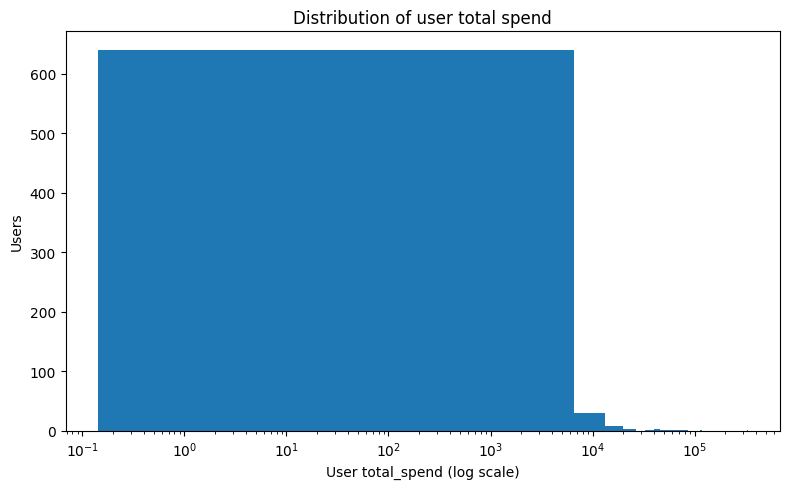

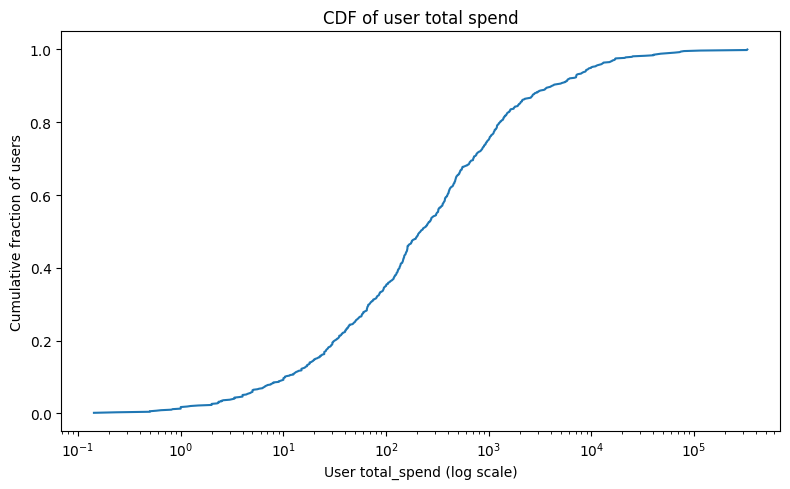

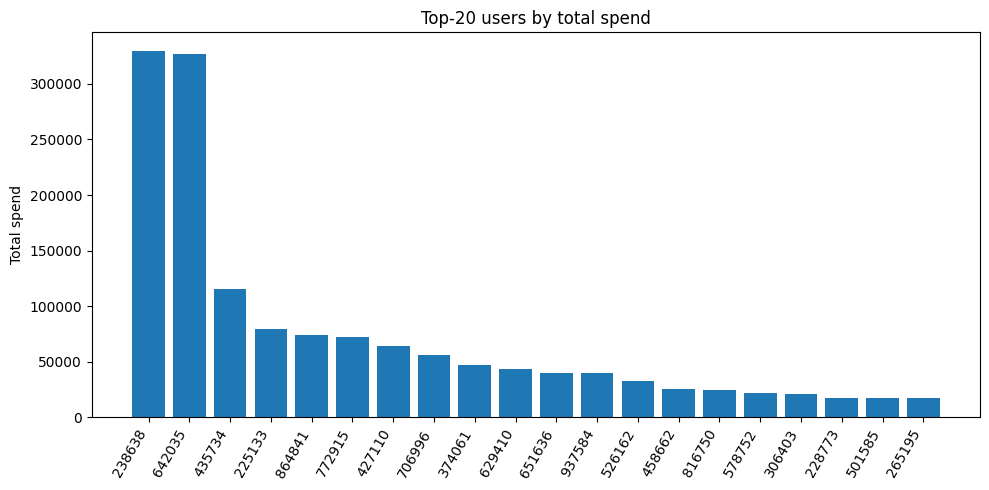

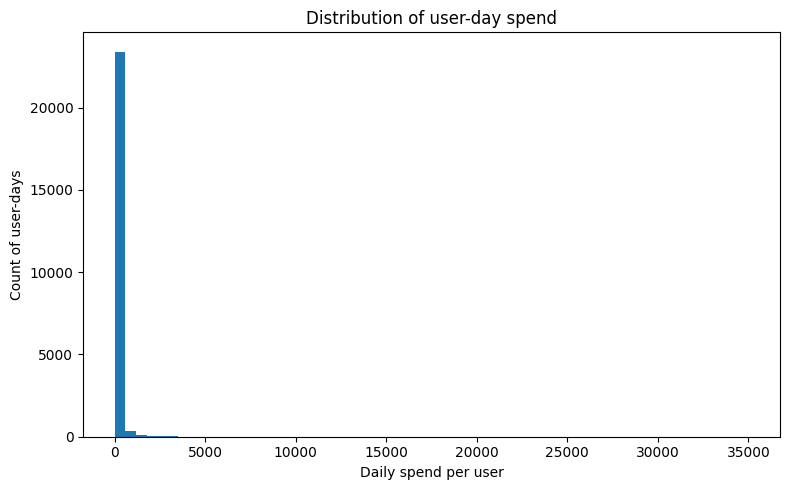

In [97]:
# ---- Roll to per-user-per-day (so one day isn't overcounted by multiple games)
df_day = (rolled_df.groupby(["mask_id","date"], as_index=False)
            .agg(day_spend=("amount_sum","sum"),
                 day_tickets=("tickets_n","sum")))

# ---- Aggregate to per-user summary
user_spend = (df_day.groupby("mask_id", as_index=False)
                .agg(total_spend=("day_spend","sum"),
                     days_active=("date","nunique"),
                     mean_daily_spend=("day_spend","mean"),
                     median_daily_spend=("day_spend","median"),
                     max_daily_spend=("day_spend","max"),
                     total_tickets=("day_tickets","sum"))
                .sort_values("total_spend", ascending=False))

# ---- Global spend quantiles (helps set caps)
qs = user_spend["total_spend"].quantile([0.90, 0.95, 0.99, 0.995, 0.999])
print("User total_spend quantiles:")
print(qs.to_frame("total_spend").round(2))

# Suggested global caps (try one in training)
cap_q = 0.99
cap_val = rolled_df["amount_sum"].quantile(cap_q)
print(f"\nSuggested training cap at q{int(cap_q*100)} = {cap_val:.2f}")

# ---- Top whales preview
top20 = user_spend.head(20).copy()
print("\nTop-20 users by total_spend:")
print(top20[["mask_id","total_spend","days_active","mean_daily_spend"]].round(2).to_string(index=False))

# =========================
# Plots (matplotlib only)
# =========================

# 1) Histogram of user total spend (log x-scale)
plt.figure(figsize=(8,5))
vals = user_spend["total_spend"].values
plt.hist(vals, bins=50)
plt.xscale("log")
plt.xlabel("User total_spend (log scale)")
plt.ylabel("Users")
plt.title("Distribution of user total spend")
plt.tight_layout()
plt.show()

# 2) CDF of user total spend (log x-scale)
plt.figure(figsize=(8,5))
sorted_vals = np.sort(vals[~np.isnan(vals)])
cdf = np.arange(1, sorted_vals.size + 1) / sorted_vals.size
plt.plot(sorted_vals, cdf)
plt.xscale("log")
plt.xlabel("User total_spend (log scale)")
plt.ylabel("Cumulative fraction of users")
plt.title("CDF of user total spend")
plt.tight_layout()
plt.show()

# 3) Top-20 whales bar chart
plt.figure(figsize=(10,5))
labels = top20["mask_id"].astype(str).tolist()
heights = top20["total_spend"].values
plt.bar(range(len(labels)), heights)
plt.xticks(range(len(labels)), labels, rotation=60, ha="right")
plt.ylabel("Total spend")
plt.title("Top-20 users by total spend")
plt.tight_layout()
plt.show()

# 4) Daily spend distribution (all users, all days)
plt.figure(figsize=(8,5))
plt.hist(df_day["day_spend"].values, bins=60)
plt.xlabel("Daily spend per user")
plt.ylabel("Count of user-days")
plt.title("Distribution of user-day spend")
plt.tight_layout()
plt.show()

#### roll up for df_validation

In [57]:
df_validation_raw = pd.read_excel("../data/raw/df_validation.xlsx")
df_validation_raw.head(5)

,mask_id,betdate,event_description,wager_amount
0,100245,2025-04-14 23:26:54,Memphis Grizzlies @ Golden State Warriors,9.99
1,100245,2025-04-14 23:28:16,Dallas Mavericks @ Sacramento Kings,10.00
2,100245,2025-04-15 16:11:59,Memphis Grizzlies @ Golden State Warriors,10.00
3,100245,2025-04-15 16:15:56,Atlanta Hawks @ Orlando Magic,10.00
4,100245,2025-04-15 22:23:55,Memphis Grizzlies @ Golden State Warriors,10.00


In [58]:
df_validation_raw.shape

(32672, 4)

In [59]:
def rollup_df_validation_no_normalize(df, path_out="../data/processed/df_validation_rolled.csv"):
    COL_ID, COL_DATE, COL_TEXT, COL_AMT = "mask_id","betdate","event_description","wager_amount"
    df["bet_dt"] = pd.to_datetime(df[COL_DATE], errors="coerce")
    df["date"]   = df["bet_dt"].dt.date
    df["amount"] = pd.to_numeric(df[COL_AMT], errors="coerce")
    keep = df[COL_ID].notna() & df[COL_ID].ne("") & df["date"].notna() & df[COL_TEXT].notna() & df["amount"].notna()
    dfx = df.loc[keep, [COL_ID,"date",COL_TEXT,"amount"]]
    rolled = (dfx.groupby([COL_ID,"date",COL_TEXT], as_index=False)
                 .agg(amount_sum=("amount","sum"), tickets_n=("amount","size")))
    rolled["date"] = pd.to_datetime(rolled["date"]).dt.strftime("%Y-%m-%d")
    rolled.rename(columns={COL_TEXT:"event_description"}, inplace=True)
    rolled.to_csv(path_out, index=False, encoding="utf-8", na_rep="")
    print("Saved:", path_out)
    return rolled

rolled_df_validation = rollup_df_validation_no_normalize(df=df_validation_raw)
print(rolled_df_validation.shape)
rolled_df_validation.head(5)

Saved: ../data/processed/df_validation_rolled.csv
(13577, 5)


,mask_id,date,event_description,amount_sum,tickets_n
0,100245,2025-04-14,Dallas Mavericks @ Sacramento Kings,10.00,1
1,100245,2025-04-14,Memphis Grizzlies @ Golden State Warriors,9.99,1
2,100245,2025-04-15,Atlanta Hawks @ Orlando Magic,10.00,1
3,100245,2025-04-15,Memphis Grizzlies @ Golden State Warriors,27.70,3
4,100245,2025-04-16,Dallas Mavericks @ Sacramento Kings,25.40,3


#### clean up playoff data

In [105]:
playoff_schedule = pd.read_csv("../data/raw/playoff_schedule.csv")
playoff_schedule

,Date,Game,event_description,winner
0,19-04-2025,Denver Nuggets & Los Angeles Clippers,Los Angeles Clippers @ Denver Nuggets,L
1,19-04-2025,Detroit Pistons & New York Knicks,New York Knicks vs. Detroit Pistons,W
2,19-04-2025,Indiana Pacers & Milwaukee Bucks,Indiana Pacers vs. Milwaukee Bucks,W
3,19-04-2025,Los Angeles Lakers & Minnesota Timberwolves,Minnesota Timberwolves @ Los Angeles Lakers,W
4,20-04-2025,Boston Celtics & Orlando Magic,Boston Celtics vs. Orlando Magic,W
...,...,...,...,...
100,11-06-2025,Indiana Pacers & Oklahoma City Thunder,Oklahoma City Thunder vs. Indiana Pacers,L
101,13-06-2025,Indiana Pacers & Oklahoma City Thunder,Oklahoma City Thunder vs. Indiana Pacers,W
102,16-06-2025,Indiana Pacers & Oklahoma City Thunder,Oklahoma City Thunder @ Indiana Pacers,W
103,19-06-2025,Indiana Pacers & Oklahoma City Thunder,Oklahoma City Thunder vs. Indiana Pacers,L


In [106]:
uni = playoff_schedule['Game'].unique()
for i in uni:
    a = len(playoff_schedule[playoff_schedule['Game']==i])
    print(a)
    if a != 7:
        print(i)

7
7
7
7
7
7
7
6
Memphis Grizzlies & Oklahoma City Thunder
7
7
7
7
7
8
Minnesota Timberwolves & Oklahoma City Thunder
7


In [107]:
playoff_schedule[playoff_schedule['Game']=='Minnesota Timberwolves & Oklahoma City Thunder']

,Date,Game,event_description,winner
84,20-05-2025,Minnesota Timberwolves & Oklahoma City Thunder,Oklahoma City Thunder vs. Minnesota Timberwolves,W
86,22-05-2025,Minnesota Timberwolves & Oklahoma City Thunder,Oklahoma City Thunder vs. Minnesota Timberwolves,W
88,24-05-2025,Minnesota Timberwolves & Oklahoma City Thunder,Oklahoma City Thunder @ Minnesota Timberwolves,L
90,26-05-2025,Minnesota Timberwolves & Oklahoma City Thunder,Oklahoma City Thunder @ Minnesota Timberwolves,W
92,28-05-2025,Minnesota Timberwolves & Oklahoma City Thunder,Oklahoma City Thunder vs. Minnesota Timberwolves,W
94,30-05-2025,Minnesota Timberwolves & Oklahoma City Thunder,NaN,NaN
96,02-06-2025,Minnesota Timberwolves & Oklahoma City Thunder,NaN,NaN
97,04-06-2025,Minnesota Timberwolves & Oklahoma City Thunder,NaN,NaN


In [110]:
AT_RE = re.compile(r"\s*@\s*", flags=re.IGNORECASE)
VS_RE = re.compile(r"\s*vs\.?\s*", flags=re.IGNORECASE)

def _parse_event(ed):
    """Return (away_team, home_team, sep) where sep in {'@','vs',None}. Robust to NaN."""
    if pd.isna(ed):
        return None, None, None
    s = str(ed).strip()
    if not s:
        return None, None, None
    if AT_RE.search(s):
        a, b = [t.strip() for t in AT_RE.split(s, maxsplit=1)]
        return a or None, b or None, "@"
    if VS_RE.search(s):
        a, b = [t.strip() for t in VS_RE.split(s, maxsplit=1)]
        # "A vs B": A is home, B is away → canonical away@home = B @ A
        return (b or None), (a or None), "vs"
    return None, None, None

def _pair_key(a: Optional[str], h: Optional[str]) -> Optional[str]:
    if not a or not h:
        return None
    return " | ".join(sorted([str(a), str(h)]))

def enrich_schedule(df,
                    path_out="../data/processed/playoff_schedule_actual_enriched.csv",
                    dayfirst=True,
                    trim_to_seven=False):
    # Preserve original columns and order BEFORE adding helper cols
    original_cols = df.columns.tolist()

    out = df.copy()
    out["_row_idx"] = np.arange(len(out))   # helper to restore order

    # Remove any leftover derived columns from earlier runs to avoid duplicate-name ambiguity
    DERIVED = {"away_team","home_team","sep","event_description_at",
               "pair_key","game_number","winner_norm","date"}
    out = out.drop(columns=[c for c in DERIVED if c in out.columns], errors="ignore")

    # Required columns
    for col in ["Date","event_description","winner"]:
        if col not in out.columns:
            raise ValueError(f"Missing required column: {col}")

    # Date → canonical YYYY-MM-DD (your file looks DD-MM-YYYY → dayfirst=True)
    out["date"] = pd.to_datetime(out["Date"], errors="coerce", dayfirst=dayfirst).dt.strftime("%Y-%m-%d")

    # Parse event_description → away/home
    split = out["event_description"].apply(parse_event).apply(pd.Series)
    split.columns = ["away_team","home_team","sep"]
    out = pd.concat([out, split], axis=1)

    # Canonical "away @ home" (do NOT modify original event_description)
    out["event_description_at"] = np.where(
        out["away_team"].notna() & out["home_team"].notna(),
        out["away_team"] + " @ " + out["home_team"],
        None
    )

    # Orientation-agnostic key
    out["pair_key"] = out.apply(lambda r: to_pair_key(r["away_team"], r["home_team"]), axis=1)

    # Keep only actual played games (your rule)
    out["winner_norm"] = out["winner"].astype(str).str.upper().str.strip()
    actual = out[(out["winner_norm"].isin(["W","L"])) & (out["event_description"].notna())].copy()

    # Number games within each (pair_key, by date) without disturbing original row order
    uniq = (actual.dropna(subset=["pair_key","date"])
                  .drop_duplicates(subset=["pair_key","date"])
                  .sort_values(["pair_key","date"])
                  .copy())
    uniq["game_number"] = uniq.groupby("pair_key").cumcount() + 1
    actual = actual.merge(uniq[["pair_key","date","game_number"]],
                          on=["pair_key","date"], how="left", sort=False)

    if trim_to_seven:
        actual = actual[(actual["game_number"].isna()) | (actual["game_number"] <= 7)].copy()

    # Restore original order, then drop helper
    actual = actual.sort_values("_row_idx")
    actual = actual.drop(columns=["_row_idx"], errors="ignore")

    # Build final column order: original first, then derived that actually exist
    derived_cols = ["date","event_description_at","away_team","home_team","sep","pair_key","game_number"]
    final_cols = [c for c in original_cols if c in actual.columns] + \
                 [c for c in derived_cols if c in actual.columns and c not in original_cols]

    # Save
    Path(path_out).parent.mkdir(parents=True, exist_ok=True)
    actual[final_cols].to_csv(path_out, index=False, encoding="utf-8")
    print(f"Saved → {path_out} | rows: {len(actual)}")
    return actual[final_cols]

In [111]:
playoff_schedule_enriched = enrich_schedule(playoff_schedule, trim_to_seven=True)
playoff_schedule_enriched.head()

Saved → ../data/processed/playoff_schedule_actual_enriched.csv | rows: 84


,Date,Game,event_description,winner,date,event_description_at,away_team,home_team,sep,pair_key,game_number
0,19-04-2025,Denver Nuggets & Los Angeles Clippers,Los Angeles Clippers @ Denver Nuggets,L,2025-04-19,Los Angeles Clippers @ Denver Nuggets,Los Angeles Clippers,Denver Nuggets,@,Denver Nuggets | Los Angeles Clippers,1
1,19-04-2025,Detroit Pistons & New York Knicks,New York Knicks vs. Detroit Pistons,W,2025-04-19,Detroit Pistons @ New York Knicks,Detroit Pistons,New York Knicks,vs,Detroit Pistons | New York Knicks,1
2,19-04-2025,Indiana Pacers & Milwaukee Bucks,Indiana Pacers vs. Milwaukee Bucks,W,2025-04-19,Milwaukee Bucks @ Indiana Pacers,Milwaukee Bucks,Indiana Pacers,vs,Indiana Pacers | Milwaukee Bucks,1
3,19-04-2025,Los Angeles Lakers & Minnesota Timberwolves,Minnesota Timberwolves @ Los Angeles Lakers,W,2025-04-19,Minnesota Timberwolves @ Los Angeles Lakers,Minnesota Timberwolves,Los Angeles Lakers,@,Los Angeles Lakers | Minnesota Timberwolves,1
4,20-04-2025,Boston Celtics & Orlando Magic,Boston Celtics vs. Orlando Magic,W,2025-04-20,Orlando Magic @ Boston Celtics,Orlando Magic,Boston Celtics,vs,Boston Celtics | Orlando Magic,1


In [112]:
len(playoff_schedule_enriched)

84